In [1]:
#SE EJECUTA LA GENERACIÓN DEL DATAFRAME LIMPIO.
#SE IMPORTA LA LIBRERIA CLEAN_DS QUE CONTIENE TODAS LAS FUNCIONES DE LIMPIEZA

from clean_ds import clean_func as fc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

help(fc.df_gen)


fc.df_gen(ruta_origen='../desafio_ds/properati.csv', ruta_destino='../desafio_ds/df_clean.csv')
data = pd.read_csv('../desafio_ds/df_clean.csv')


Help on function df_gen in module clean_ds.clean_func:

df_gen(ruta_origen='../desafio_ds/properati.csv', ruta_destino='../desafio_ds/df_clean.csv')
    :param ruta_origen: ruta del dataframe de properati
    :param ruta_destino: ruta donde se escribira el dataframe corregido
    :return: aplica las funciones completar, filtar_errores y imputar_floor_room

Se completaron con el patron TYPE HOUSE: 37960 registros
Se completaron con el patron SIN EXPENSA: 1165 registros
Se completaron con el patron EXPENSAS MONTO: 4095 registros
Total original de NULLs para expenses: 106958
Total actual de NULLs para expenses: 63738
Porcentaje de NULLs corregidos para expenses: 40.0%
Se completaron con el patron TYPE HOUSE: 43599 registros
Se completaron con el patron PRIMER.SEGUNDO.....PISO: 2822 registros
Se completaron con el patron 1ER....2DO.....PISO: 1261 registros
Se completaron con el patron 1..2.....PISO: 609 registros
Se completaron con el patron PISO...1..2....: 3264 registros
Se completaron c

872500.0
-347500.0


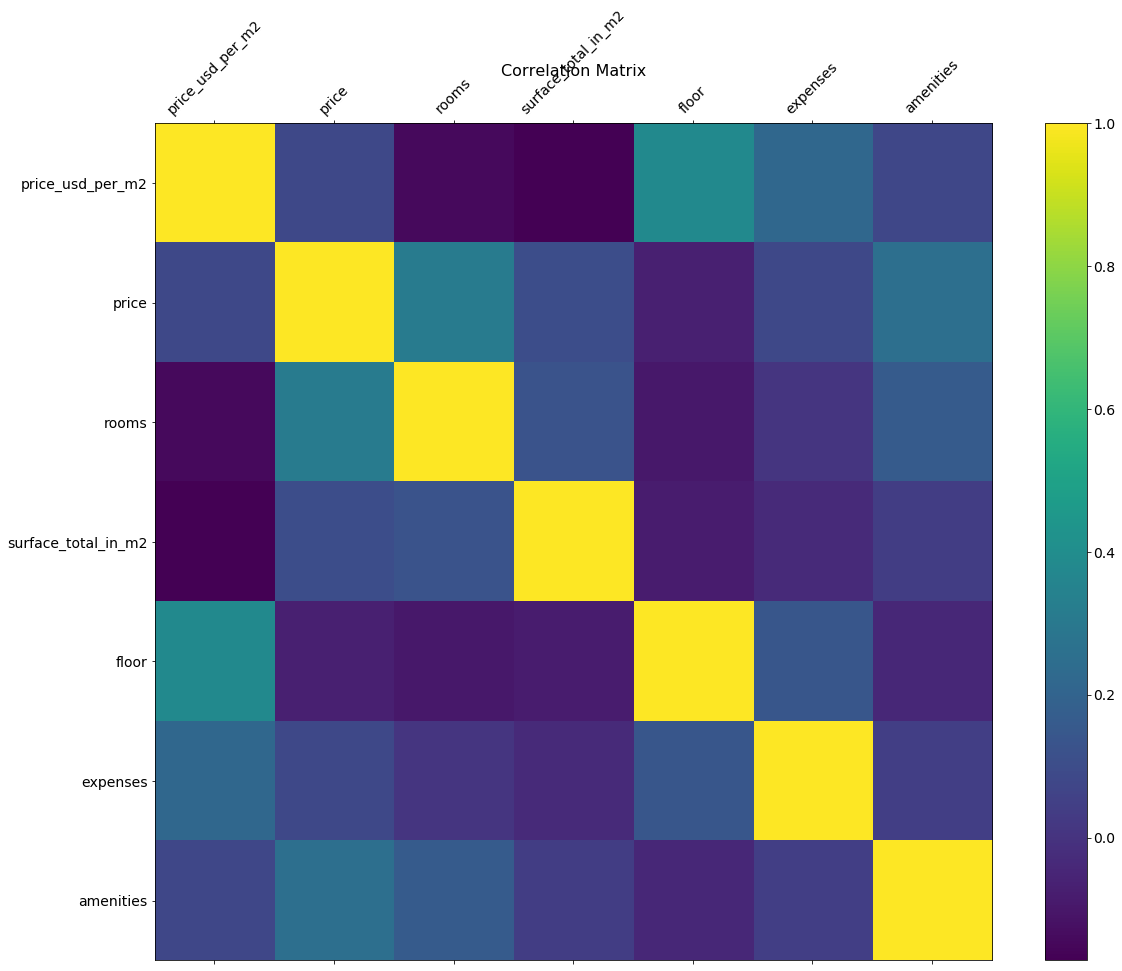

In [3]:
#Como primer paso de nuestro análisis, realizamos un gráfico de correlación entre todas las variables de interés

#determinamos cuartiles para detectar outliers

q1 = data['price'].quantile(0.25)
q2 = data['price'].quantile(0.5)
q3 = data['price'].quantile(0.75)
q4 = data['price'].quantile(1)

iqr = (q3 - q1) * 1.5
up_thresh = q3 + iqr
low_thresh = q1 - iqr
print(up_thresh)
print(low_thresh)

outlier_mask_up = data['price'] > up_thresh
outlier_mask_down = data['price'] < low_thresh
mask_outliers = np.logical_or(outlier_mask_up, outlier_mask_down)
mask_not_outliers = np.logical_not(mask_outliers)
outliers = data.price[mask_outliers]

data_no_outliers = data.loc[mask_not_outliers].copy()
data_no_outliers.shape

data_no_outliers["place_name"].value_counts().head(20)

mask_10 = (data_no_outliers["place_name"] == "Mar del Plata") | (data_no_outliers["place_name"] == "Rosario")\
| (data_no_outliers["place_name"] == "Córdoba") | (data_no_outliers["place_name"] == "Nordelta")\
| (data_no_outliers["place_name"] == "Tigre") | (data_no_outliers["place_name"] == "Palermo")\
| (data_no_outliers["place_name"] == "Belgrano") | (data_no_outliers["place_name"] == "Caballito")\
| (data_no_outliers["place_name"] == "Pilar") | (data_no_outliers["place_name"] == "Olivos")\
& (data_no_outliers["property_type"] == "apartment")
data_no_outliers_final = data_no_outliers[mask_10]
data_no_outliers_final.loc[:, "place_name"].value_counts()

df = data_no_outliers_final[["price_usd_per_m2", "price", "rooms", "surface_total_in_m2", "floor", "expenses", "amenities"]]


f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

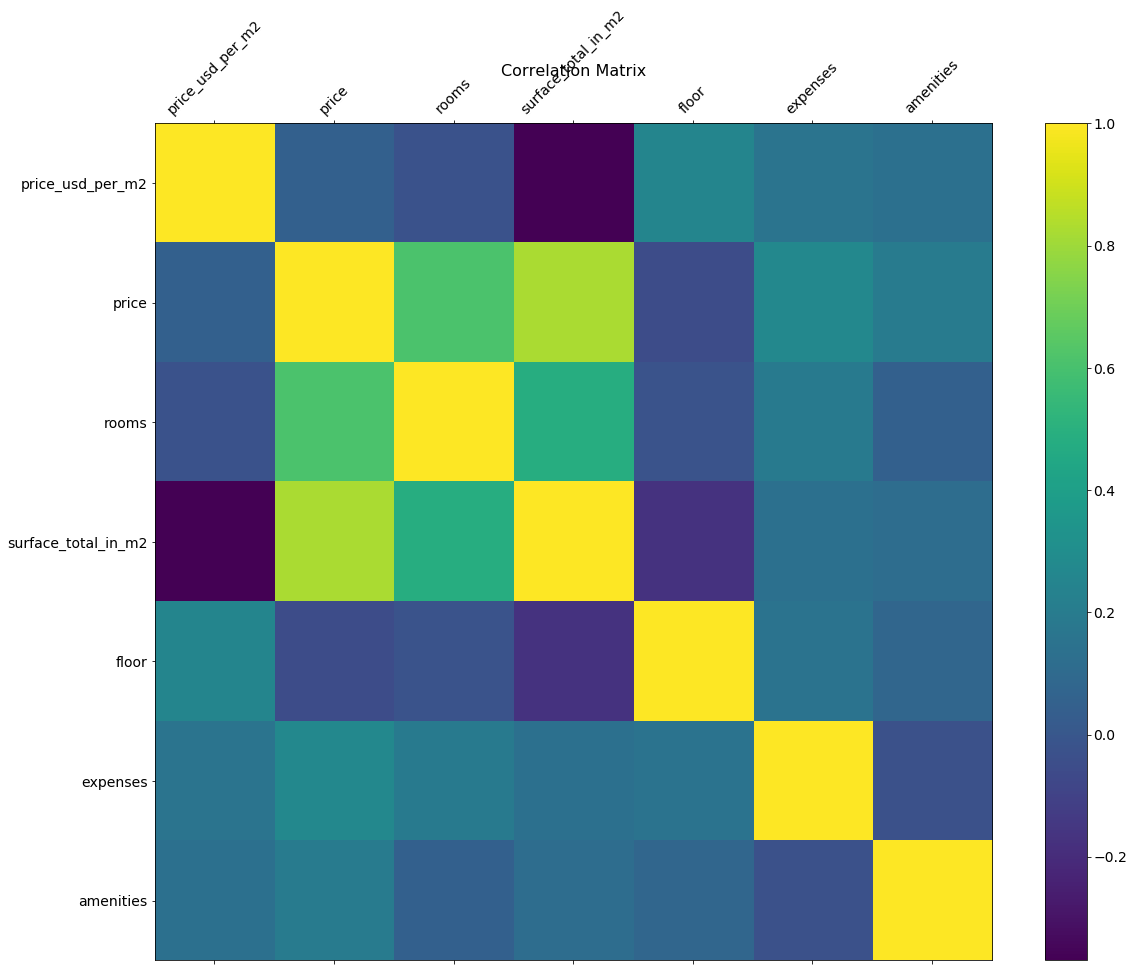

In [4]:
#Realizamos el mismo gráfico de correlación pero centrando el análisis en el barrio de Caballito

mask_caballito = (data_no_outliers["place_name"] == "Caballito")# & (data_no_outliers["property_type"] == "apartment")
data_no_outliers_caballito = data_no_outliers[mask_caballito]
data_no_outliers_caballito.loc[:, "place_name"].value_counts()

df3 = data_no_outliers_caballito[["price_usd_per_m2", "price", "rooms", "surface_total_in_m2", "floor", "expenses", "amenities"]]

f3 = plt.figure(figsize=(19, 15))
plt.matshow(df3.corr(), fignum=f3.number)
plt.xticks(range(df3.shape[1]), df3.columns, fontsize=14, rotation=45)
plt.yticks(range(df3.shape[1]), df3.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

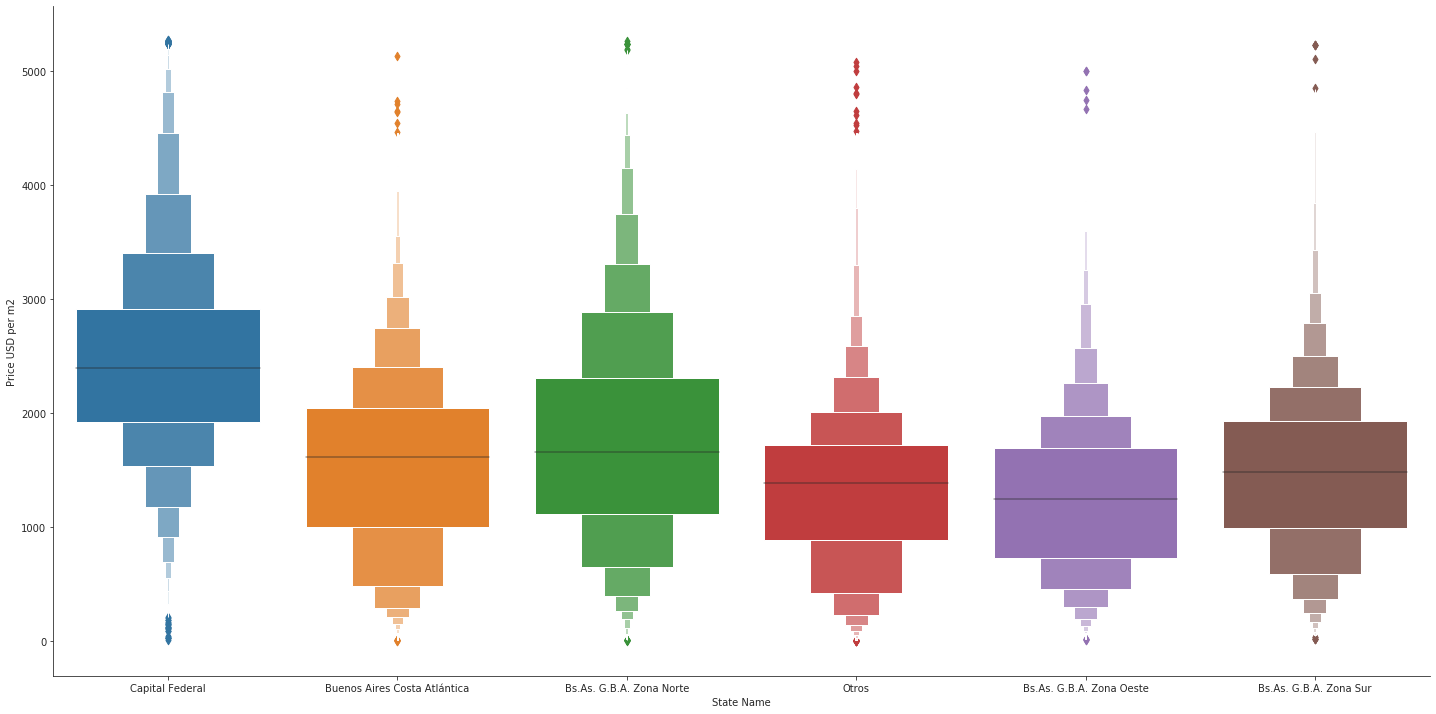

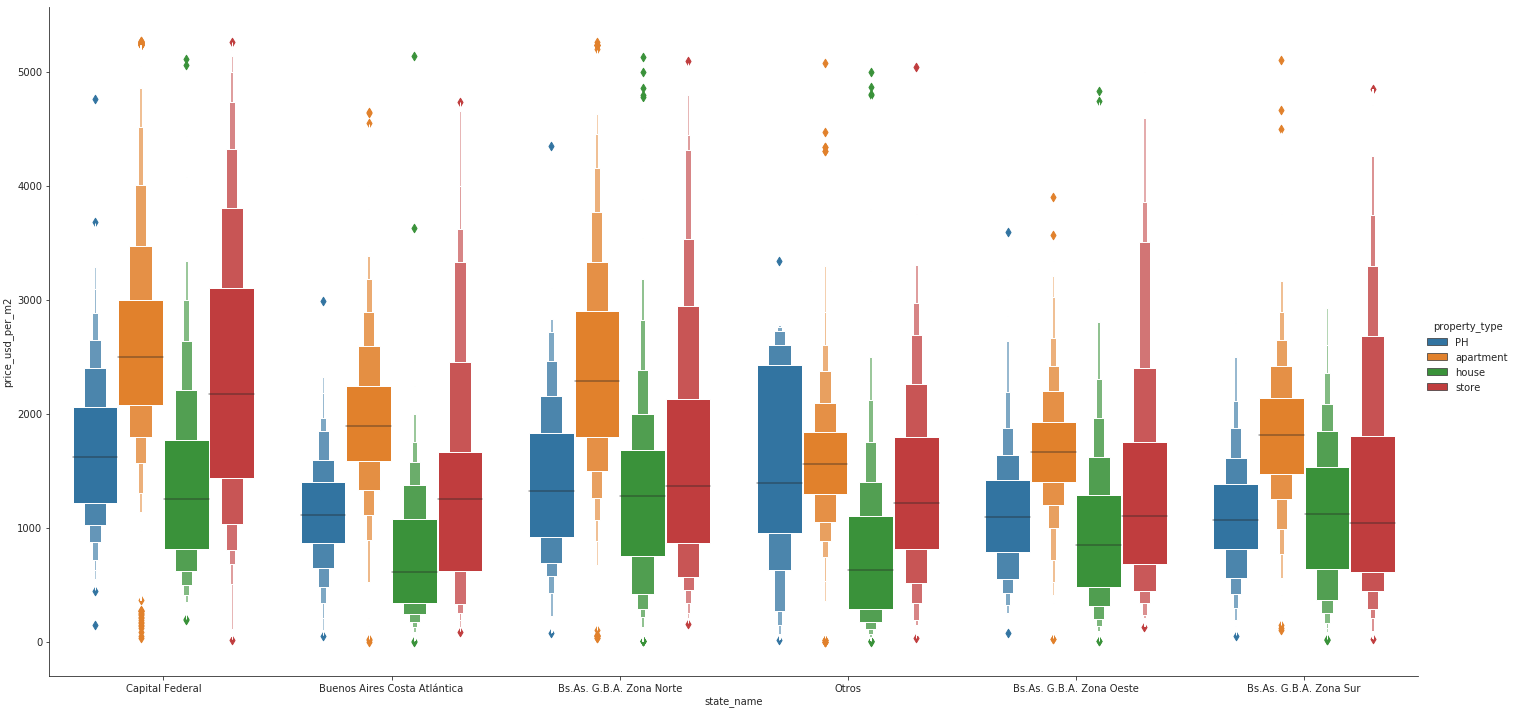

In [5]:
# Luego realizamos gráfica de boxplot filtrando por los principales distritos
## ¿Cuantas observaciones tenemos por state name?
(data.groupby('state_name')['Unnamed: 0'].count()/data.shape[0]*100).sort_values(ascending=False)

## Para acotar las variables de análisis, enmarco dentro de la categoria "otros a aquellas locaciones que quedan por fuera de los states contenedores del 80% de las observaciones

filtro_pareto= ['Capital Federal', 'Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur',
            'Buenos Aires Costa Atlántica','Bs.As. G.B.A. Zona Oeste']
pareto_states=data.state_name.apply(lambda x: x if x in filtro_pareto else x.replace(x,'Otros'))
data['states_pareto']=pareto_states

## Definimos una máscara para quedarnos con un subgrupo de la población sin valores extremos
data_w_outliers = data.loc[data.price_usd_per_m2<data.price_usd_per_m2.mean()+3*data.price_usd_per_m2.std()]

## Analizamos mediante un boxplot la distribución de precios por los grupos geográficos previamente definidos
with sns.axes_style(style='ticks'):
    g = sns.catplot("states_pareto", "price_usd_per_m2",data=data_w_outliers, kind="boxen", height=10, aspect=2)
    g.set_axis_labels('State Name', "Price USD per m2");

## Adicionalmente, el análisis se puede ampliar si agregamos como Hue los tipos de propiedad, en donde vemos cómo dentro de cada grupo geográfico, cada tipo de propiedad tiene una distribuciòn similar respecto al precio en usd por m2
with sns.axes_style(style='ticks'):
    g = sns.catplot("states_pareto", "price_usd_per_m2",'property_type', \
                    data=data_w_outliers, kind="boxen", height=10, aspect=2,\
                   legend=True)
    g.set_axis_labels('state_name', "price_usd_per_m2");

In [10]:
mask_capfed = data['state_name'] == 'Capital Federal'
data_cap_fed_not_outl = data.loc[mask_capfed]
sns.boxplot(x="property_category", y="price_corregido", data=data_cap_fed_not_outl, palette='Paired')


ValueError: Could not interpret input 'property_category'